# Analysing the Online Network of Pegida

<img src="http://www.methodds.de/images/PEGIDA_DRESDEN_DEMO_12_Jan_2015.jpg" <span title="Pegida demonstration on 12 January 2015 after the Charlie Hebdo shooting. Source: English Wikipedia" alt="Drawing" style="width: 700px; height: 400px;"/>

Since Octobre 2014, the German anti-Islam organization  **Patriotic Europeans Against the Islamization of the West**, abbreviated **[Pegida](http://en.wikipedia.org/wiki/Pegida 'Wikipedia Link: Pegida'),** is hosting weekly demonstrations mainly against German and European Asylum policy decisions and the allegedly ongoing [islamization](http://en.wikipedia.org/wiki/Islamization 'Wikipedia Link: Islamization') of Germany.       
Pegida is using a [Facebook Page](http://www.pegida.de 'www.pegida.de - link to the official Pegida Facebook Community Page') as primary online representation which is liked by over 159.000 usersat the time of writing *(Feb 2015)*. There also exists a closed [fan-group](https://www.facebook.com/groups/622400881199793/ 'link to the official pegida fan group) which can only be accessed after a group administrator's approval of a join request.        

This notebook demonstrates basic techniques of text and network analysis to investigate on topics discussed in public and to understand the network structures of Pegida's online presence. The code for the analysis is written in ```Python```.

In [2]:
# importing Python libraries
import pandas as pd
import networkx as nx
import community as com
import collections
import math
import operator
import re
import numpy as np
import nltk
import seaborn as sns
from nltk.corpus import stopwords
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Pegida - International News

Wile Pegida is a common subject for German media, news about the political right-wing organization and its demonstrations are also covered by the international press. The following barchart is generated using a logfile for [major world publications](http://www.lexisone.com/legalresearch/lnbcc/contentlistings/newspeople_c.html) about Pegida tracked on LexisNexis Academic  from Octobre 2014 to Mid-February 2015 and shows the number of articles within 15 day periods.

In [ ]:
# changing working directory
%cd '/LinuxData/LexisDocs'
# opening file
with open('log_file_02-19-2015.txt', 'r') as f:
    docs = []
    for line in f:
        #find dates and counts in every log entry
        dates = re.findall(r'[0-9]{2}/[0-9]{2}', line)
        count = re.findall(r'([0-9]{1,4}).documents', line)
        try:
            docs.append(tuple([str(dates[0] + '-' + dates[1]), count[0]]))
        except IndexError:
            docs.append(tuple([str(dates[0] + '-' + dates[1]), 0]))
            
doc_array = np.array(docs)

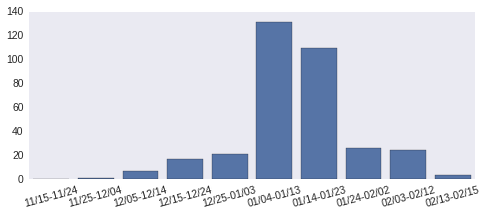

In [303]:
#visualization parameters
sns.set_palette("deep", desat=0.8)
sns.set_context('paper', font_scale=1.3, rc={"figure.figsize": (8, 3)})
plt.xticks(rotation=15)
sns.barplot(doc_array[:,0],doc_array[:,1].astype(float), 
            x_order=doc_array[:,0] )

The distribution approximately follows the number of [Pegida Participants in Dresden](http://en.wikipedia.org/wiki/Pegida#Participants_and_supporters), which declined after the resignments of famous Pegdia speakers like *Kathrin Oertel*.

## Pegida Closed Group: User Friendships

Due to the name  of the Pegida Group (*PEGIDA - Official Fan Group*) and its closed structure, one can assume that most members of this group strongly sympathize with Pegida and its motives. Although texts of group interactions will not be shown in this part, one image which was posted by administrators shall be sufficient to illustrate the predominant political attitudes.

![image](https://www.dropbox.com/s/0psvsjs4q1h8qcb/1476240_1542894482649625_201931955681901158_n.jpg?dl=1)    

*Translation:*

> **CAUTION WARNING!**
>
> It is to be expected that the crime rate will increase dramatically as temperatures are raising. 
> All the asylum seekers will realise soon that they can do whatever they want in Germany anyway without 
> being prosecuted or deported. To put it plainly this means:
> - Burglary
> - Rape
> - Violence against Germans
>
> I'm begging all members of this group to be very carefull!
> I don't want to read that something happens to you!


There are several possibilities to analyse network structures on social-media sites like Facebook. Here, group members are represented by nodes and friendships between members are represented by connections in form of edges. As friendships between Facebook users always require mutual approvement, the network is undirected.    
I used the Facebook Application [netvizz](http://rieder.polsys.net/files/rieder_websci.pdf) to extract friendships between all group members .

### Gender Distribution

Because graphs generated from netvizz are anonymized, gender is pretty much the only socio-demographic variable that can be examined without manually extracting data from Facebook. As you can see in the following output, the gender distribution is heavily skewed: about 4/5 of the group members are men.

In [3]:
#loading graph
G = nx.read_gml('pegida_group.gml', relabel=True)

In [4]:
# iterating through all nodes, counting sex attribute
sex = []
for node in G.node.items():
    if 'sex' in node[1]:
        sex.append(node[1]['sex'])
    else:
        sex.append('na')        
counter=collections.Counter(sex)
dist = counter.most_common(3)

print 'Men:  ', str(float(dist[0][1])/len(G.nodes())) + '%'
print 'Women:', str(float(dist[1][1])/len(G.nodes())) + '%'

Men:   0.779101245263%
Women: 0.220628045479%


### Network Analysis

Starting off with the network size, there are a total of 3694 group members with more than 10.000 friendships between them. While there exist far larger network structures with [billions of nodes](http://snap.stanford.edu/data/index.html 'SNAP Databasee'), this is not a small network either.

In [359]:
print 'Nodes:',len(G.nodes()), ', Edges:',len(G.edges())

Nodes: 3694 , Edges: 10983


Next, several concepts of [graph theory](http://en.wikipedia.org/wiki/Glossary_of_graph_theory ' Wikipedia: Glossary of graph theory') will be applied for better understanding of the network structure.    

The **degree** of a node is the number of its direct connections. A group member with 3 intra-group friendships therefore would have a degree of 3. Nodes with high degrees are for example central for spreading information and influencing other neighborhood nodes. Summing up all degrees and dividing the sum by the number of nodes results in the average degree. As you can see below, on average the Pegida group members have about 6 friendships.


In [47]:
deg = G.degree()
average_deg = np.sum(deg.values()) / float(len(G.nodes()))
print 'Average Degree:' ,average_deg

Average Degree: 5.94639956687


Another measure for the importance of a node is **eigenvector centrality**. Eigenvectors basically detect who is connected to the other most connected nodes in a network and therefore can be interpretated as an instance of [social capital](http://en.wikipedia.org/wiki/Social_capital 'Wikipedia: Social Capital'). A group member with high eigenvector centrality has a lot of friends who themselves have many connections.   
For the Pegida group, the five highest eigenvector centralities do not differ very much, which indicates that there are is no central user who has friendships to many well-connected people.

In [15]:
soc = nx.eigenvector_centrality_numpy(G)
for k,v in sorted(soc.iteritems(), key=operator.itemgetter(1),reverse = True)[:5]:
    print 'User_ID:', k[5:15], '\tEigenvector Centrality:', v

User_ID: 77cbbec264 	Eigenvector Centrality: 0.1371875012
User_ID: 3076d925ee 	Eigenvector Centrality: 0.136810808456
User_ID: 16ce179224 	Eigenvector Centrality: 0.130703610248
User_ID: 07b73059fe 	Eigenvector Centrality: 0.130336543705
User_ID: 671df1f734 	Eigenvector Centrality: 0.124493448346


Network **density** describes the ratio of edges over the total number of possible edges between all nodes in a network. In *cliques* with a density of 1, all nodes would be connected to each other. In this case, the density is relatively low.

In [12]:
print 'Network Density:', nx.density(G)

Network Density: 0.00161018130703


To identify groups within a network the **clustering coefficient** measures the degree to which nodes tend to cluster together. Social networks usually are highly clustered, meaning that there are several groups with many intra-connections. For Pegida however, the average clustering coefficient is pretty low. 

In [310]:
print 'Average Clustering Coefficient:', nx.average_clustering(G)

Average Clustering Coefficient: 0.108950406975


One explanation for the low density and clustering in the network is a potential lack of regional connectivity. Many group members probably joined because of their political attitude and not because of friends already being part of the group. It is to be expected that such members will not have a lot of friends within the group, which is not necessary for interacting with group members anyway.

To further investigate in this, I extracted all **components** from the network. Components are subgraphs in the network in which all nodes are somehow connected to each other. As you can see below, there are a total of 1996 components within the group, which is more than half of the overall number of nodes. Identifying the five biggest components reveals that there is one central connected subgraph with almost 2000 group members, while in comparison all other components are fairly small. Although there are no location data available for this analysis, I assume that many members in the big component are regionally close to each other, possibly living in the area of Dresden, the origin town of Pegida.

In [354]:
# checking wether all nodes in the network are connected
nx.is_connected(G)

False

In [7]:
# extracting the 5 biggest subgraphs
components = [len(graph.nodes()) for graph in nx.connected_component_subgraphs(G)]
print 'Number of components:', len(components)
print 'Five biggest components:', sorted(components, reverse=True)[:5]

Number of components: 1996
Five biggest components: [1560, 12, 6, 5, 4]


To find communities within a network one common approach are **[modularity](http://en.wikipedia.org/wiki/Modularity_%28networks%29 'Wikipedia: Modularity')** based algorithms. While modularity and clustering appear to measure similar concepts, the mathematics behind are quite different. Here, a package by [Blondel et al.](http://perso.crans.org/aynaud/communities/ 'Community detection') will be used to automatically extract communities. Because of the sparse network structure, the algorithm finds 2015 communities, which clearly cannot all be interpreted as a social groups sharing similar attitudes - many of the communities only consist of one single node.

In [14]:
m_com = com.best_partition(G)
m = com.modularity(m_com, G)
print 'Extracted Communities:', len(set(m_com.values()))

Extracted Communities: 2015


Another important aspect of network analysis is visualization. For the following graph, node positions are adjusted using a [force-directed algorithm](http://en.wikipedia.org/wiki/Force-directed_graph_drawing 'Wikipedia Link: Force-directed graph drawing'). Additionally, the size of a node is based on its degree and the colors represent corresponding communities.

In [48]:
# adjusting degree weights for visualization node-size
deg_norm = [(math.log(val) + 1) * 30  if val > 0 else 20 for val in deg.values() ]
# getting community values
values = [m_com.get(node) for node in G.nodes()]
# positioning nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

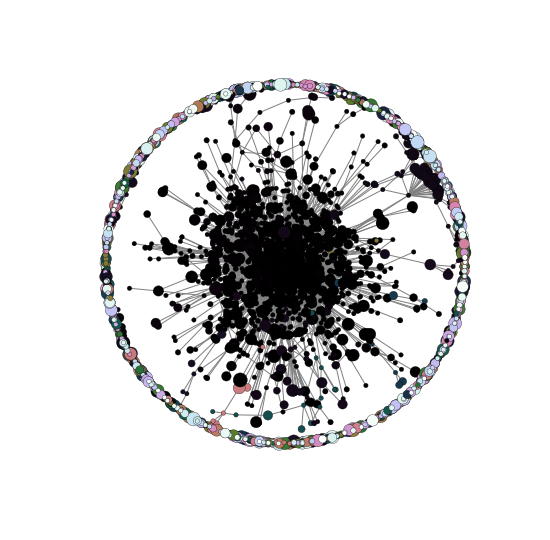

In [74]:
#visualization parameters
fig = plt.figure(figsize=(7,7))
nx.draw(G, pos=pos, with_labels=False, node_color = values, 
        edge_color='grey', node_size=deg_norm, cmap='cubehelix')

The outer ring of this visualization displays the large number of group members who do not have any friendships within the group. In the middle of the graph you can see the biggest component of the network. Because of the very sparse connectivity and therefore large number of extracted communities, the colors can't really be interpreted clearly.

#### Extracting biggest component

Putting all members with very few or no connections aside, the biggest component will be isolated and analysed separately.

In [4]:
# iterating through all subgraphs to extract the biggest component
sub_graphs = list(nx.connected_component_subgraphs(G))
cur_graph = sub_graphs[0]
for graph in sub_graphs:
    if len(graph.nodes()) > len(cur_graph.nodes()):
        cur_graph = graph

biggest_sup = cur_graph
H = biggest_sup

In comparison to the complete graph, the nodes in the subgraph have, on average, more than double the number of direct connections. This, together with the higher density was to be expected, as most group members with low connectivity have been removed. Additionally, in comparison to over 2000 in the complete graph, only 22 communities were detected.

In [17]:
# Computing Graph Statistics
deg2 = H.degree()
average_deg2 = np.sum(deg2.values()) / float(len(H.nodes()))
m_com2 = com.best_partition(H)
m2 = com.modularity(m_com2, H)
print 'Nodes:',len(H.nodes()), ', Edges:',len(H.edges())
print 'Average Degree:' ,average_deg2
print 'Average Clustering Coefficient:', nx.average_clustering(H)
print 'Network Density:', nx.density(H)
print 'Extracted Communities:', len(set(m_com2.values()))

Nodes: 1560 , Edges: 10808
Average Degree: 13.8564102564
Average Clustering Coefficient: 0.238076990355
Network Density: 0.00888801171033
Extracted Communities: 22


Another concept of graph theory is the **average shortest path length**, which is computed as the average number of steps along the shortest paths in the network for every possible node pair. Here, on average every group member is connected to another member over less than 4 people.

In [363]:
print 'Average Length of Shortest Paths:',nx.average_shortest_path_length(H)

Average Length of Shortest Paths: 3.82387954145


This measure can be used together with the clustering coefficient to compare the network with a random graph that has **[small world](http://en.wikipedia.org/wiki/Small-world_network 'Wikipedia: Small-world network')** properties. Social networks like Facebook (see [here](http://www.cio.com/article/2371799/facebook/it-s-a-small-world--facebook-slices-separation-to-4-74-degrees.html 'Facebook Small Worl')) commonly have small world attributes which results in a short average path length and high clustering. 

In [16]:
def sw_compare(G,k=4,p=0.3):
    '''function for comparing an input graph with a random smallworld graph'''
    SW = nx.watts_strogatz_graph(len(G.nodes()), k, p)
    print 'SW - Clustering Coefficient:', nx.average_clustering(SW),\
    ', Input - Clustering Coefficient:', nx.average_clustering(G), "\n" 
    print 'SW - Avg. Shortest Path Length:', nx.average_shortest_path_length(SW),\
    ', Input - Avg. Shortest Path Length:', nx.average_shortest_path_length(G)

In [343]:
sw_compare(H)

SW - Clustering Coefficient: 0.188371489621 , Input - Clustering Coefficient: 0.238076990355 

SW - Avg. Shortest Path Length: 6.67674133649 , Input - Avg. Shortest Path Length: 3.82387954145


The clustering coefficients for  the biggest component and the random network are very similar, whereas the average shortest path length is quite a bit smaller for the pegida subgraph. Note however that this is only one random graph and for every new comparison, different results are to be expected.

Finally, the subgraph will also be visualized by using the same methods as before.

In [35]:
# adjusting average degree weights for visualization node-size
deg_norm = [(math.log(val) + 1) * 30  if val > 0 else 20 for val in deg2.values() ]
# getting community values
values2 = [m_com2.get(node) for node in H.nodes()]
# positioning nodes using Fruchterman-Reingold force-directed algorithm
pos_H = nx.spring_layout(H)

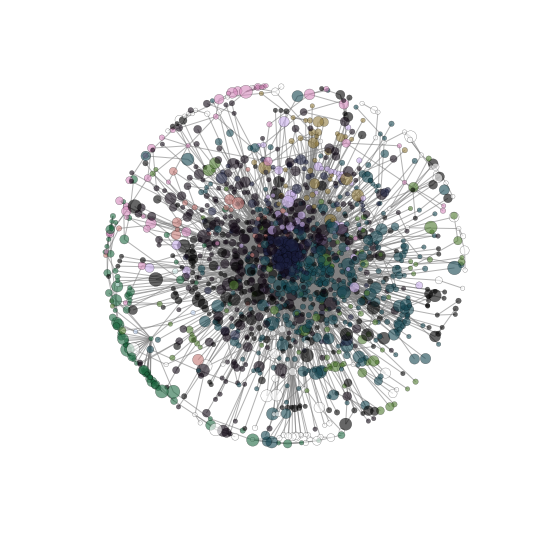

In [79]:
#visualization parameters
fig = plt.figure(figsize=(7,7))
nx.draw(H, pos=pos_H, with_labels=False, edge_color = 'gray', alpha=0.6,
        node_color=values2, node_size=deg_norm, cmap='cubehelix',vmin = 0.5, vmax = 12)

In this graph the community structure is easier to detect. Besides the larger groups in the center one can find several subgroups, for example at the bottom left.

Summing up, the closed pegida group is a very sparse, male dominated network which consists of one huge subgraph und many poorly or not at all connected isolated members. Unfortunately, no additional socio democraphic data were available. For different approaches, the group network could also be modeled with edges as shared engagements on group posts.

## Pegida Community Page

While the Pegida group represented a rather closed social environment, the main online appearance of Pegida is the [Facebook Community Page](http://www.pegida.de 'www.pegida.de - link to the official Pegida Facebook Community Page'). For this page, every Facebook user can read, like, comment and share content without having to like the page or any administrator approval. Most of the users interacting on the community page are probably still sympathizing with Pegida, although in contrast to the closed group some people also publicly criticize the organization.    

To analyse the Facebook page, the latest 100 page posts have been extracted with netvizz and every user who interacted with post content is recognized. This enables the construction of a [bipartite](http://en.wikipedia.org/wiki/Bipartite_graph 'Wikipedia: Bipartite Graph') network with users and page content, which will be shown at the end of this notebook.     
Additionally, for every post all textual elements have been mined, including comments for that post. The next part will show how easy it is to analyse such large text corpora with Python.

### Pegida Community Page - Text Analysis

As the text data for the 100 page posts is saved in a tabular format, it can easily be converted to a DateFrame. You can see in the column ```comment_published``` that post dates range from 02/01/2015 to 02/18/2015.

In [83]:
# loading page posts into dataframe
df = pd.read_csv('page_pegida100_comments.tab', usecols=['post_text', 
    'post_published', 'comment_message', 'comment_published', 'comment_like_count'],  sep='\t')

In [84]:
#displaying the first 5 rows of the dataframe
df.head(5)

,post_text,post_published,comment_message,comment_published,comment_like_count
0,Herr Stoiber_ Sie sind hiermit offiziell als ...,2015-02-18T19:30:22+0000,Das denk ich mir auch,2015-02-18T19:33:31+0000,2
1,Herr Stoiber_ Sie sind hiermit offiziell als ...,2015-02-18T19:30:22+0000,Bravo bravo bravo !!!,2015-02-18T19:35:28+0000,3
2,Herr Stoiber_ Sie sind hiermit offiziell als ...,2015-02-18T19:30:22+0000,"Morgen steht in der BILD ""Stoiber als Nazi ent...",2015-02-18T19:44:05+0000,2
3,Herr Stoiber_ Sie sind hiermit offiziell als ...,2015-02-18T19:30:22+0000,"Es scheint eine Wende zu geben, was die Asylpo...",2015-02-18T19:47:17+0000,2
4,Herr Stoiber_ Sie sind hiermit offiziell als ...,2015-02-18T19:30:22+0000,Endlich mal einer der nicht einfach nur die Fr...,2015-02-18T19:31:45+0000,38


In [94]:
# displaying the last row of the dataframe
df.tail(1)

,post_text,post_published,comment_message,comment_published,comment_like_count
91230,Eine tolle Aktion sowie ein guter Anfang. (Y) ...,2015-01-27T00:53:31+0000,So muss das sein ! Das ist Pegida ! https://st...,2015-02-01T19:10:22+0000,2


This dataframe could be used for further statistical analysis, which is beyond the scope of this notebook. For the following text analysis, the content of posts and comments will be exported to separate lists.

##### Posts

For natural language processing, several cleaning strategies can be used to improve data quality. First, the text sequences will be split into single strings, which is called **tokenizing**.

In [89]:
# exporting posts to list
posts = list(set(df["post_text"].tolist()))
# tokenizing
posts = [nltk.word_tokenize(post.decode('utf8').lower()) for post in posts]

Each post is now saved as a singe list with all words represented as separate items.

In [96]:
# tokenized version of the latest post
print posts[0][:10]

[u'hallo', u'freunde_', u'auch', u'das', u'umstrukturierte', u'orgateam', u'bleibt', u'seiner', u'linie', u'treu']


To remove content with no semantic meaning, the text will also be cleaned from stop words such as *and*, *is* or *the*. In addition, tokens will be reduced to their root forms, so that for example *argue* and *arguing* will be saved as *argu*, which is useful for computing frequency distributions and matching words with similar meanings.   
You can see below that the cleaning process removes more than 50% of the textual elements.

In [375]:
#loading stopwords and stemmer
stopwords = stopwords.words('german')
stopwords = stopwords + ['http', 'https', 'dass', 'ja', 'mal', 'schon', 'mehr']
snowball = nltk.SnowballStemmer('german')
#combining the lists
p_combined = [token for post in posts for token in post]
# removing stopwords and stemming
p_combined_clean = [token for post in posts for token in post if token.isalnum() and not token in stopwords]
p_combined_clean_s = [snowball.stem(token) for token in p_combined_clean]
# converting to text object
posts_text = nltk.Text(p_combined)
posts_text_clean =  nltk.Text(p_combined_clean_s)
print 'Number of Tokens     (raw):', len(p_combined)
print 'Number of Tokens (cleaned):', len(p_combined_clean)

Number of Tokens     (raw): 6584
Number of Tokens (cleaned): 2504


It is easy to explore the context in which a specific word is used. As *islamization* is an important topic for Pegida activists, one could search for usage of the word *islam* in the posts.

In [306]:
posts_text.concordance(u'islam', width=100)

Displaying 5 of 5 matches:
ert _multi-kulti-romantik_ und sagt_ warum der islam für ihn nicht zu deutschland gehört. ( ... ) h
anten satz : _wenn angela merkel behauptet der islam gehöre zu deutschland_ dann ist das der beweis
ei sie nicht dazu ermächtigt zu behaupten_ der islam gehöre zu deutschland . „es ist nicht die aufg
en bürgern in deutschland zu erklären_ was der islam sei_ weist abdel-samad die kanzlerin zurecht. 
wird_ desto unerbittlicher wird jede kritik am islam von der politik verfolgt._ ( ... ) https : //w


The five posts which contain *Islam* seem to deal with the question whether the Islam should belong to Germany or not, what was [stated by Angela Merkel in January](http://www.reuters.com/article/2015/01/12/us-germany-islam-merkel-idUSKBN0KL1S020150112 'Reuters: Merkel - Islam').

Another interesting concept is the co-appearance of several worlds. Such **collocations** basically detect [n-grams](http://en.wikipedia.org/wiki/N-gram 'Wikipedia: N-Grams') which appear unusually often. Here, bigrams for the cleaned text are shown, as raw text bigrams are inflated by stopwords.

In [141]:
posts_text_clean.collocations()

lutz bachmann; neumarkt dresd; friedlich marsch; ehrenamt mitarbeit;
kern hooligan; manfred baasn; polizeireform 2020; regierungsfreund
statist; wattenscheid tafel; uhr neumarkt; alfon proebstl; gesetz
grundlag; hooligan gewaltbereit; zugesproch bekomm; strass geh;
kommend oberburgermeisterwahl; martin luth; neu vorstand; seid spitz;
2020 stopp


Some of the collocations in the posts are refering to persons, like Lutz Bachmann who was the founder of Pegida. There are also hints for discussions about future demonstrations and police reforms.

##### Comments

The same cleaning techniques can now be used for the comments to every post.

In [142]:
# exporting comments to list
comments = df["comment_message"].tolist()
# tokenizing
comments = [nltk.word_tokenize(str(comment).decode('utf8').lower()) for comment in comments]

Almost 3 billion tokens have been extracted from the comments, which results in about 1 billion tokens in the cleaned version.

In [376]:
c_combined = [token for comment in comments for token in comment]
c_combined_clean = [token for comment in comments for token in comment if token.isalnum() and not token in stopwords]
c_combined_clean_s = [snowball.stem(token) for token in c_combined_clean]
comments_text = nltk.Text(c_combined)
comments_text_clean =  nltk.Text(c_combined_clean_s)
print 'Number of Tokens     (raw):', len(c_combined)
print 'Number of Tokens (cleaned):', len(c_combined_clean)

Number of Tokens     (raw): 2793972
Number of Tokens (cleaned): 1113707


Another important buzzword for Pegida activists is the term 'Lügenpresse', which refers to alleged lies from the German press regarding Pegida and is used almost 1000 times in the comments. The concordances below also reveal some Anti-Pegida comments which make fun of the commonly used term.

In [305]:
comments_text.concordance(u'lügenpresse', lines=10, width=100)

Displaying 10 of 982 matches:
chen aschermittwoch in osterhofen zum thema lügenpresse : `wenn tausende menschen schweigend und fr
ie vor ein gericht musst . ihr redet von `` lügenpresse '' und erliegt den billigsten fakes . armes
nö ... . ganz einfach schwachsinn den diese lügenpresse verbreitet . mut zur lüge würde besser pass
 schon länger vom staatsschutz beobachtet . lügenpresse sind alle anderen , es sei denn jemand schr
ern von nazis '' trifft hat das doktrin der lügenpresse und der toleranzromantikpolitik seine volle
eine1 mit sternchen in mathematik , für die lügenpresse und ihren angestellten eine 6 und versetzun
rdoppelt . seit november 2014 strategie der lügenpresse . bei vielen ist hopfen und malz verloren ?
gegeneinander aufzuwiegeln . und medien als lügenpresse hinzustellen zeugt genauso von eurer intell
z wieder dehnen . wie war das noch gleich ? lügenpresse ? ist euer slogan jetzt out ? herr pissb ..
po 24 ! hm , mal überlegen ... dresdner : d lügenpresse ! 1 ! drölf ! 

For collocations in the comments, most are again dealing with named entities. You can find a reference to the German Green Party and the names of several Pegida activists and politicians.

In [147]:
comments_text_clean.collocations()

lutz bachmann; strass geh; frau oertel; frau merkel; bundnis grun;
claudia roth; joschka fisch; cem ozdemir; genn predigtbefugnis; uns
polit; direkt demokrati; felix genn; predigtbefugnis entzog; paul
spatling; bischof felix; orga team; worauf bischof; bedau einzelfall;
bla bla; pegida anhang


For the last insight to methods of text analysis, the frequency distribution of the 15 most common words will be displayed in a bar chart.

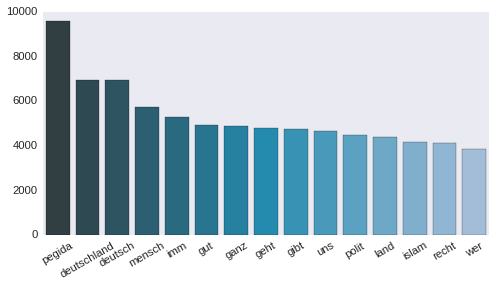

In [295]:
# getting frequency distribution of tokens
comments_fdist = nltk.FreqDist(comments_text_clean)
comments_fdist_15 = np.array(comments_fdist.most_common(15))

#visualization parameters
sns.set_style('dark')
sns.set_palette("deep", desat=.6)
sns.set_context('paper', font_scale=1.4,rc={"figure.figsize": (8, 4)})
plt.xticks(rotation=30)
sns.barplot(comments_fdist_15[:,0],comments_fdist_15[:,1].astype(float), 
            x_order=comments_fdist_15[:,0], palette="PuBuGn_d")

By far the most common term is unsurprisingly *Pegida* with almost 10.000 appearances. Besides some semantically uninteresting words, you can also find *recht* (which can be translated as *right* in the context of justice), *islam* and the stemmed token *polit*, which stands for terms like *politics* or *politicians*.

Besides these basic demonstrations of natural language processing, more advanced techniques like [semantic analysis](http://en.wikipedia.org/wiki/Semantic_analysis 'Wikipedia: Semantic analysis') could be used for further investigations. The final part of this notebook however is showing another approach to network analysis.

### Pegida Community Page - Network Analysis

While Python is scaling very well for computing network measures for billions of nodes, appealing visualizations of very large networks are hard.   
For the Pegida community page a bipartite network has been extracted with [Gephi](http://gephi.github.io/)  and the [Sigma Explorer](http://blogs.oii.ox.ac.uk/vis/) to show the interaction between users and posts by page administrators . All nodes without any interactions have been removed. The graph with 43809 nodes and 215994 edges can be explored either by following the [directlink](http://methodds.de/pegida_graph/ "Pegida Facebook Network") or using the ```iPython-frame``` below. 
Clicking on a specific node will display additional information like the sex of a user, the number of likes or the text of a page post.   

In [288]:
from IPython.display import HTML
HTML('<iframe src=http://methodds.de/pegida_graph/ width=900 height=650></iframe>')

As nodes closer to the center represent users who are more engaged, you can see that such active users tend to interact with links, while less active users are more interested in photos or status updates.   
One possible explanation for this is a temporal aspect: Users who spend more time on the page and are deeper engaged with Pegida also take the time to examine link content besides other posts. Less engaged users in comparison rather interact with non-time consuming media like photos.

## Conclusion

Exploring the Pegida Facebook appearances revealed some insights in network structures and commonly discussed topics. For further research, more socio-demographic data for the users would enable much more sophisticated analysis, although acquiring such information without privacy issues is hardly possible. Analysing networks and text at several points and comparing the results in a longitudinal study could also show the development of Pegida appearances and related discussions over time.    

Research aside, the large number of people sympathizing with Pegida is deeply disgracing for me. The textual content in the closed (and selective) group was so disturbing that related analysis were not included in this notebook. Luckily, there are far more people demonstrating [**against**](https://web.archive.org/web/20150111154808/http://www.bbc.com/news/world-europe-30765674') Pegida than supporting the extreme right-wing organization. It is to hope that the existence of Pegida is as short living as its demonstrations were upsetting.

 ![image](https://dl.dropboxusercontent.com/u/22352379/antipegida.jpg 'Protesters against Pegida. Source: BBC Web Archive')

<HR color="black">

<HR color="black">

Interested in learning Python? Check this [link](https://github.com/methodds/Data-Science/blob/master/Python%20Setup%20and%20iPython%20Notebook%20Examples.ipynb).    

** Feel free to contact me: carsten.schwemmer@uni-bamberg.de**